<a href="https://colab.research.google.com/github/OleksiiLatypov/mlzoomcamp-capstone01/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython import display
import os
import math
from keras.preprocessing import image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as python_random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import Callback, EarlyStopping


import seaborn as sns
import math
import random
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D,MaxPool2D, Dense, Flatten, Dropout
import tensorflow.lite as tflite



 Set random seed to ensure reproducibility of results

In [2]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
!wget https://github.com/OleksiiLatypov/DQE/raw/main/archive.zip

--2025-01-13 12:22:42--  https://github.com/OleksiiLatypov/DQE/raw/main/archive.zip
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/OleksiiLatypov/DQE/main/archive.zip [following]
--2025-01-13 12:22:42--  https://media.githubusercontent.com/media/OleksiiLatypov/DQE/main/archive.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 165557612 (158M) [application/zip]
Saving to: ‘archive.zip’

archive.zip         100%[===================>] 157.89M   325MB/s    in 0.5s    

2025-01-13 12:22:47 (325 MB/s) - ‘archive.zip’ saved [165557612/165557612]



In [ ]:
!unzip '/content/archive.zip'

Define the path to the training and testing  dataset

In [5]:
train_path = '/content/Covid19-dataset/train'
test_path = '/content/Covid19-dataset/test'

Retrieve the names of the subdirectories inside the train_path directory, and assign them to the variable name_classes

In [6]:
name_classes = os.listdir(train_path)
name_classes

['Viral Pneumonia', 'Normal', 'Covid']

In [7]:
covid_dir = os.path.join(train_path, 'Covid')
num_of_covid = len(os.listdir(covid_dir))

normal_dir = os.path.join(train_path, 'Normal')
num_of_normal = len(os.listdir(normal_dir))

pneumonia_dir = os.path.join(train_path, 'Viral Pneumonia')
num_of_pneumonia = len(os.listdir(pneumonia_dir))


print(f'There are {num_of_covid} images with Covid diagnosis')
print(f'There are {num_of_normal} images with Normal diagnosis')
print(f'There are {num_of_pneumonia} images with Pneumona diagnosis')


There are 111 images with Covid diagnosis
There are 70 images with Normal diagnosis
There are 70 images with Pneumona diagnosis


Visualizing image distribution

<ipython-input-8-6f9674cf10a1>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=name_classes, y=num_images, palette='viridis')


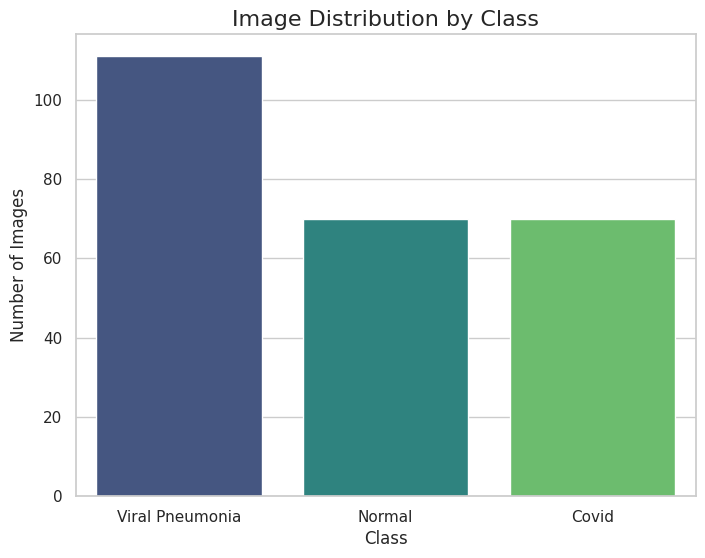

In [8]:
num_images = [num_of_covid, num_of_normal, num_of_pneumonia]

# Set up the seaborn style
sns.set(style="whitegrid")

# Create the bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=name_classes, y=num_images, palette='viridis')

# Add titles and labels
plt.title('Image Distribution by Class', fontsize=16)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)

# Show the plot
plt.show()


Randomly sample 5 images from the Covid, Normal and Viral Pneumonia directories

In [ ]:
five_covid_images = random.sample(os.listdir(covid_dir), 5)
five_normal_images = random.sample(os.listdir(normal_dir), 5)
five_viral_images = random.sample(os.listdir(pneumonia_dir), 5)

print(f'5 Covid random images: {five_covid_images}')
print(f'5 Normal random images: {five_normal_images}')
print(f'5 Viral Pneumonia random images: {five_viral_images}')

5 Covid random images: ['091.jpg', 'COVID-00022.jpg', '079.jpeg', '083.jpeg', 'COVID-00021.jpg']
5 Normal random images: ['09.jpeg', '013.jpeg', '017.jpeg', '094.jpeg', '02.jpeg']
5 Viral Pneumonia random images: ['076.jpeg', '034.jpeg', '052.jpeg', '096.jpeg', '013.jpeg']


Loading an images from a specified file path, resizes it to a target size, and normalizes its pixel values to the range [0, 1].

In [ ]:
def load_image_path(img_path: str, target_size=(224, 224)):
    """
    Loads an image from the given path, resizes it, and scales the pixel values to [0, 1].

    Parameters:
        img_path (str): Path to the image file.
        target_size (tuple): The target size to which the image should be resized (default is (224, 224)).

    Returns:
        np.ndarray: The processed image as a NumPy array.
    """
    # Load image with the target size
    img = image.load_img(img_path, target_size=target_size)

    # Convert the image to a NumPy array
    img_array = image.img_to_array(img)

    # Rescale the image array to the range [0, 1]
    rescale_img = img_array / 255.0

    return rescale_img


In [ ]:
joined_images = [
    (covid_dir, five_covid_images, 'Covid'),
    (normal_dir, five_normal_images, 'Normal'),
    (pneumonia_dir, five_viral_images, 'Viral Pneumonia')
]

Displaying random images from different classes

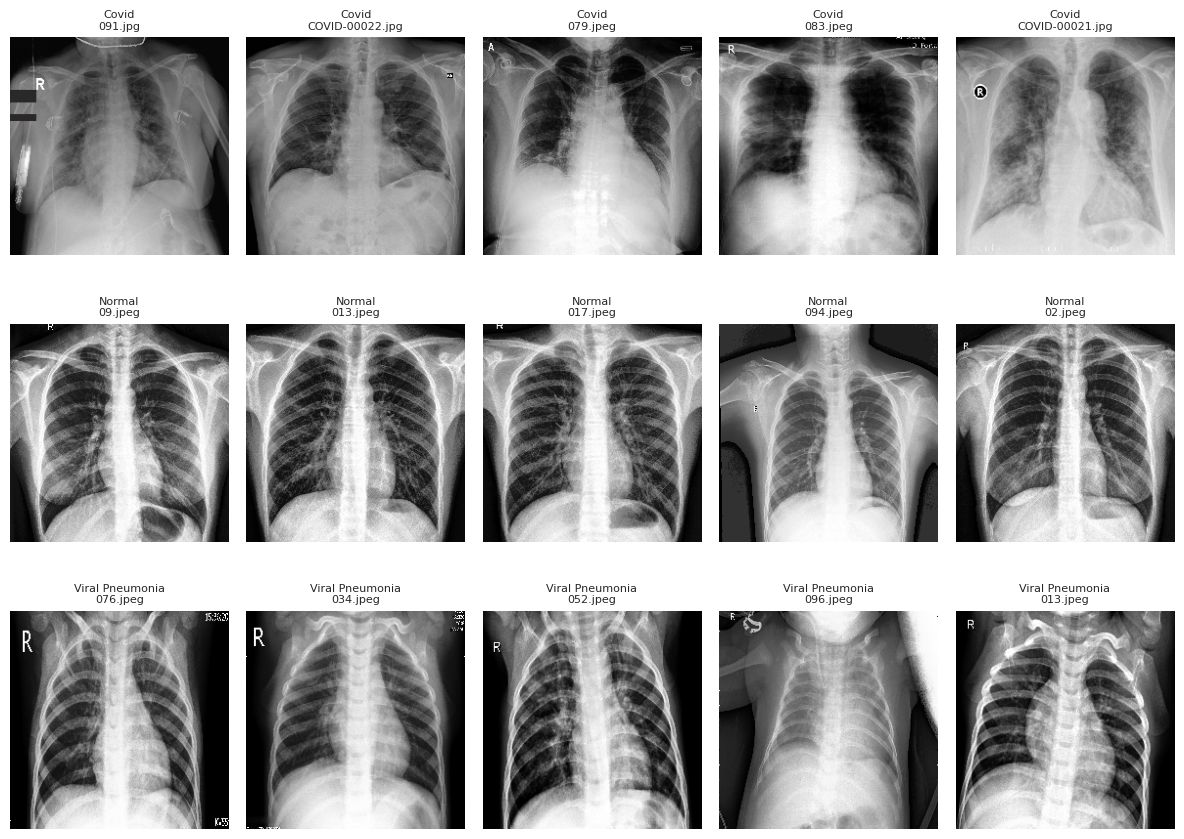

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 9))  # 5 rows, 3 columns
axes = axes.flatten()  # Flatten the axes array to iterate easily

# Initialize a counter for the subplot index
index = 0

# Loop through directories and images
for image_dir, image_list, label in joined_images:
    for image_name in image_list:
        image_path = os.path.join(image_dir, image_name)
        image_to_load = load_image_path(image_path)

        # Plot the image in the current subplot
        axes[index].imshow(image_to_load)
        axes[index].set_title(f'{label}\n{image_name}', fontsize=8)
        axes[index].axis("off")  # Turn off axes

        index += 1  # Move to the next subplot

# Hide any remaining unused subplots (if total images < grid size)
for i in range(index, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

Lets apply **ImageDataGenerator** for training. It normalizes the pixel values of images by dividing by 255 to scale them into the range [0, 1]. Additionally, it applies a 20% validation split, meaning 80% of the training data will be used for training and 20% for validation during model training.

In [ ]:
datagen_train=ImageDataGenerator(rescale=1./255.,validation_split=0.2)
datagen_test=ImageDataGenerator(rescale=1./255.)

In [ ]:
SIZE=(224,224)

Load and preprocess images directly from a directory structure for training a neural network

In [ ]:
train_data = datagen_train.flow_from_directory(batch_size=32,
                                            directory=train_path,
                                            shuffle=True,
                                            classes=name_classes,
                                            target_size=SIZE,
                                            subset="training",
                                            class_mode='categorical')
validation_data = datagen_train.flow_from_directory(batch_size=32,
                                            directory=train_path,
                                            shuffle=True,
                                            classes=name_classes,
                                            subset="validation",
                                            target_size=SIZE,
                                            class_mode='categorical')
test_data = datagen_train.flow_from_directory(batch_size=1,
                                            directory=test_path,
                                            shuffle=False,
                                            classes=name_classes,
                                            target_size=SIZE,
                                            class_mode='categorical')

Found 201 images belonging to 3 classes.
Found 50 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


Create the **CNN model**

CNN architecture with three convolutional blocks (each with a Conv2D and MaxPool2D layer) followed by two fully connected layers and a softmax output layer. It's a standard architecture for image classification tasks. The increasing number of filters in the convolutional layers allows the network to learn progressively more complex features, while the max pooling layers reduce dimensionality and add robustness. The final softmax layer provides class probabilities.

In [ ]:
def create_cnn_model(input_shape=(224, 224, 3), num_classes=3):
    """
    Function to create a CNN model with 3 convolutional layers and 2 fully connected layers.

    Parameters:
    - input_shape (tuple): Shape of the input image, default is (224, 224, 3) for RGB images.
    - num_classes (int): Number of output classes for classification, default is 3.

    Returns:
    - model: A Keras Sequential model.
    """
    model = Sequential()

    # First convolutional layer
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPool2D((2, 2)))

    # Second convolutional layer
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPool2D((2, 2)))

    # Third convolutional layer
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPool2D((2, 2)))

    # Flatten the 3D feature map to 1D vector for fully connected layers
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))

    # Output layer with softmax activation for multi-class classification
    model.add(Dense(num_classes, activation='softmax'))

    return model


In [ ]:
cnn_model = create_cnn_model()

Check a detailed summary of the model's architecture.

In [ ]:
cnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,177,411 (42.64 MB)

 Trainable params: 11,177,411 (42.64 MB)

 Non-trainable params: 0 (0.00 B)

Prepare the model for training by setting the necessary configurations for the optimizer, loss function, and evaluation metric.

* **optimizer**='adam': Adam (Adaptive Moment Estimation) is an efficient optimizer
that adapts the learning rate during training. It's a commonly used optimizer due to its fast convergence and low memory requirements.

* **loss**='categorical_crossentropy': This is the appropriate loss function for multi-class classification problems, where each sample is assigned to one of several classes. Categorical cross-entropy measures the difference between the true label and the predicted probability distribution.

* **metrics**=['accuracy']: Accuracy is used to measure how often the model's predictions match the true labels. It's a standard metric for classification tasks and is monitored during training.

In [ ]:
cnn_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

Apply custom callback, which allows to stop the training early once the model achieves 95% accuracy, saving time and computational resources

In [ ]:
class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        # Check if accuracy has reached or exceeded 95%
        if logs.get('val_accuracy') >= 0.95:
            print("\nReached More than 95% accuracy")
            self.model.stop_training = True  # Stop training early

# Initialize the custom callback instance
callback = myCallback()


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',        # Metric to monitor, can be 'accuracy' or 'val_accuracy'
    min_delta=0.0001,               # Minimum change to qualify as an improvement
    patience=7,                     # Number of epochs with no improvement before stopping
    verbose=1,                      # Print the message when early stopping is triggered
    restore_best_weights=True      # Restore the best weights when stopping
)

In [ ]:
hist=cnn_model.fit(train_data,epochs=30,validation_data=validation_data, callbacks=[callback, early_stopping])

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 871ms/step - accuracy: 0.4562 - loss: 2.4576 - val_accuracy: 0.7400 - val_loss: 0.8928
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 299ms/step - accuracy: 0.8446 - loss: 0.7046 - val_accuracy: 0.7800 - val_loss: 0.4434
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 305ms/step - accuracy: 0.8465 - loss: 0.4602 - val_accuracy: 0.8000 - val_loss: 0.5124
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 327ms/step - accuracy: 0.8336 - loss: 0.3877 - val_accuracy: 0.8800 - val_loss: 0.3978
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 303ms/step - accuracy: 0.9153 - loss: 0.2514 - val_accuracy: 0.8600 - val_loss: 0.4406
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 491ms/step - accuracy: 0.8999 - loss: 0.2506 - val_accuracy: 0.9200 - val_loss: 0.2512
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 299ms/step - accuracy: 0.9681 - loss: 0.1345 - val_accuracy: 0.9200 - val_loss: 0.2110
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 298ms/step - accuracy: 0.9858 - loss: 0.0592 - val_accuracy: 0.9400 - val_loss

 Visualize the performance of the model during training. By plotting both the **training accuracy** and **validation accuracy** over epochs, you can:

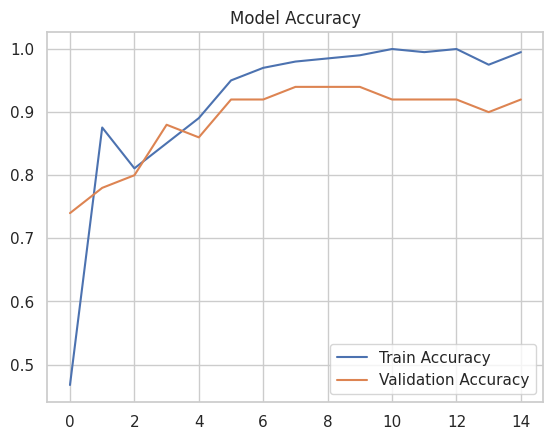

In [ ]:
plt.figure()
plt.plot(hist.history["accuracy"],label="Train Accuracy")
plt.plot(hist.history["val_accuracy"],label="Validation Accuracy")
plt.title("Model Accuracy")
plt.legend()
plt.show()

Visualize the performance of the model during training. By plotting both the **training loss** and **validation loss** over epochs, you can

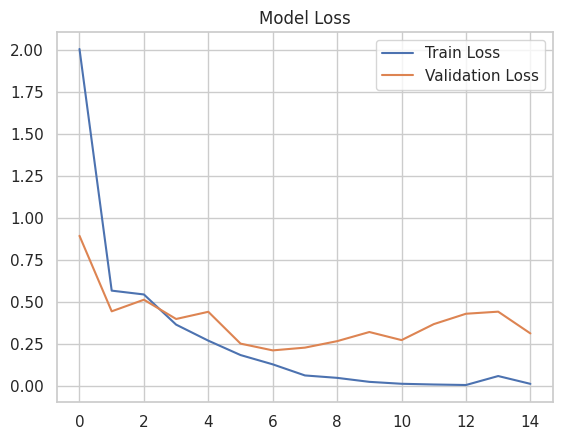

In [ ]:
plt.figure()
plt.plot(hist.history["loss"],label="Train Loss")
plt.plot(hist.history["val_loss"],label="Validation Loss")
plt.title("Model Loss")
plt.legend()
plt.show()

**Evaluating Model Performance**, to assess how well the model generalizes to unseen data. It gives a final measure of how the model performs outside the training and validation datasets.

In [ ]:
cnn_model.evaluate(test_data)

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9327 - loss: 0.1972


[0.3830163776874542, 0.9090909361839294]

Make predictions on the test set, converts those predictions to class labels, and prepares the true labels and class names for further evaluation

In [ ]:
predictions=cnn_model.predict(test_data)
y_pred=[np.argmax(probas) for probas in predictions]
y_test=test_data.classes
class_names=test_data.class_indices.keys()

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


Display **classification report**, which povides a detailed performance evaluation of the model based on precision, recall, F1-score, and support

In [ ]:
# Generate classification report
report = classification_report(y_test, y_pred, target_names=name_classes)

# Print the classification report
print(report)


                 precision    recall  f1-score   support

Viral Pneumonia       0.86      0.90      0.88        20
          Covid       0.90      1.00      0.95        26
         Normal       1.00      0.80      0.89        20

       accuracy                           0.91        66
      macro avg       0.92      0.90      0.90        66
   weighted avg       0.92      0.91      0.91        66



Visualize a detailed breakdown of how the model's predictions align with the true labels. It helps in identifying misclassifications across different classes.

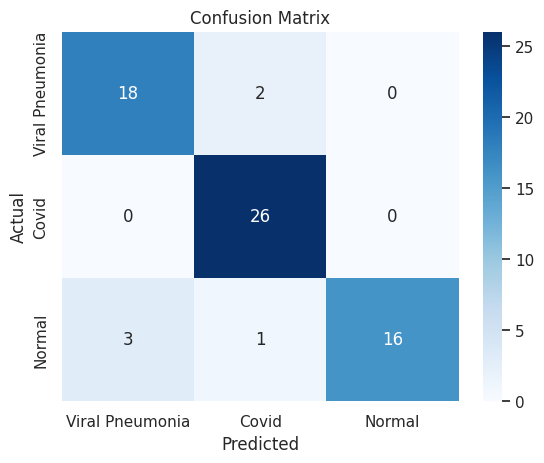

In [ ]:
cm=confusion_matrix(y_test,y_pred)
confusion_df=pd.DataFrame(cm,index=name_classes,columns=name_classes)
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Save the model

In [ ]:
try:
    # Try saving the model
    cnn_model.save('cnn_model_with.h5')
    print("Model saved successfully!")

except Exception as e:
    # Catch any exception and print the error message
    print(f"An error occurred while saving the model: {e}")

Model saved successfully!


Convert serverless

In [ ]:
# Load your saved model
model = load_model('cnn_model_with.h5')


# Convert the Keras model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(cnn_model)
tflite_model = converter.convert()

# Save the converted TensorFlow Lite model
with open('converted_model.tflite', 'wb') as file:
    file.write(tflite_model)

print("Model successfully converted to converted_model.tflite")


Saved artifact at '/tmp/tmp5c8b8jqo'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  140411172087664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140411133754560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140411132652960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140411131426096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140411131926256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140411131920448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140411131932768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140411131933824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140411131932592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140411070988704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14041107099240

In [ ]:
print(f"Converted Model Size: {os.path.getsize('./cnn_model_with.h5') / (1024 * 1024) } Mb")

Converted Model Size: 127.9686279296875 Mb


In [ ]:
print(f"Converted Model Size: {os.path.getsize('./converted_model.tflite') / (1024 * 1024) } Mb")

Converted Model Size: 42.64258575439453 Mb


# Image Augmentation

The training data is augmented using various transformations on training data to improve the model's ability to generalize to new data. This includes random rotations, shifts, zooms, shears, and flips. These augmentations help the model learn more robust features.

In [ ]:
# Apply rescaling and augmentation to the training data
datagen_train_aug = ImageDataGenerator(
    rescale=1./255.,             # Rescale pixel values to [0, 1]
    validation_split=0.2,        # Split the data, 20% for validation
    rotation_range=40,           # Random rotation within ±40 degrees
    width_shift_range=0.2,       # Random width shift by 20%
    height_shift_range=0.2,      # Random height shift by 20%
    shear_range=0.2,             # Random shear transformation
    zoom_range=0.2,              # Random zoom by 20%
    horizontal_flip=True,        # Random horizontal flip
    fill_mode='nearest'          # Fill empty pixels after transformation with nearest pixel value
)

# Training data generator with augmentation
train_data_aug = datagen_train_aug.flow_from_directory(
    batch_size=32,
    directory=train_path,
    shuffle=True,
    classes=name_classes,
    target_size=SIZE,
    subset="training",  # Use the 'training' subset from the split
    class_mode='categorical'
)


Found 201 images belonging to 3 classes.


In [ ]:
hist_aug=cnn_model.fit(train_data_aug, epochs=20,validation_data=validation_data,callbacks=[callback])

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 531ms/step - accuracy: 0.5451 - loss: 1.9540 - val_accuracy: 0.6600 - val_loss: 0.8619
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 477ms/step - accuracy: 0.5934 - loss: 0.9509 - val_accuracy: 0.6400 - val_loss: 0.8216
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 297ms/step - accuracy: 0.5474 - loss: 0.8983 - val_accuracy: 0.8600 - val_loss: 0.6321
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 304ms/step - accuracy: 0.6646 - loss: 0.7427 - val_accuracy: 0.7400 - val_loss: 0.6873
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 285ms/step - accuracy: 0.6830 - loss: 0.6804 - val_accuracy: 0.8200 - val_loss: 0.5200
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 299ms/step - accuracy: 0.6890 - loss: 0.5876 - val_accuracy: 0.8400 - val_loss: 0.5265
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 295ms/step - accuracy: 0.7589 - loss: 0.5578 - val_accuracy: 0.8800 - val_loss: 0.4750
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 385ms/step - accuracy: 0.6819 - loss: 0.8315 - val_accuracy: 0.8200 - val_loss: 0.4974
Ep

Visualize the performance of the model during training with Image Augmentation. By plotting both the **training accuracy** and **validation accuracy** over epochs, you can:

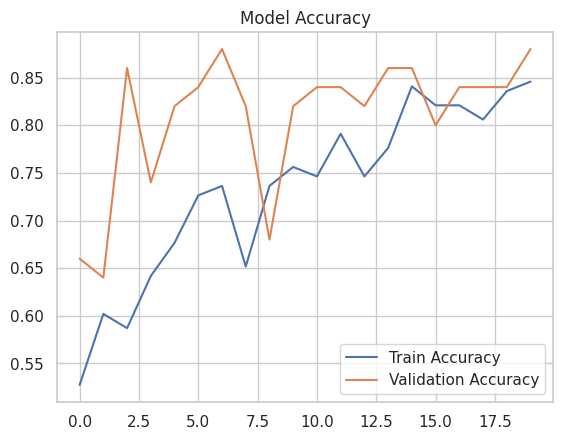

In [ ]:
plt.figure()
plt.plot(hist_aug.history["accuracy"],label="Train Accuracy")
plt.plot(hist_aug.history["val_accuracy"],label="Validation Accuracy")
plt.title("Model Accuracy")
plt.legend()
plt.show()

Visualize the performance of the model during training with Image Augmentation. By plotting both the **training loss** and **validation loss** over epochs, you can:

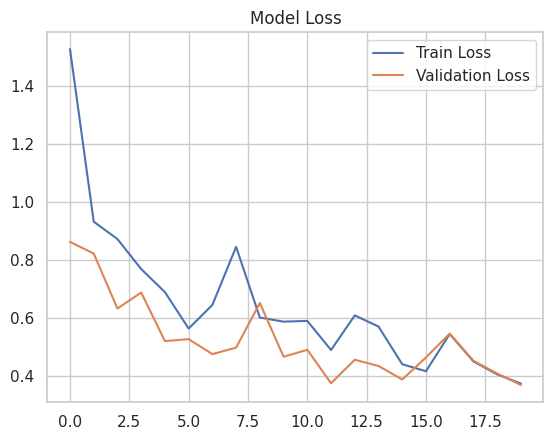

In [ ]:
plt.figure()
plt.plot(hist_aug.history["loss"],label="Train Loss")
plt.plot(hist_aug.history["val_loss"],label="Validation Loss")
plt.title("Model Loss")
plt.legend()
plt.show()

Evaluating Model Performance.

In [ ]:
cnn_model.evaluate(test_data)

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8249 - loss: 0.5407


[0.507064700126648, 0.7878788113594055]

In [ ]:
predictions=cnn_model.predict(test_data)
y_pred=[np.argmax(probas) for probas in predictions]
y_test=test_data.classes
class_names=test_data.class_indices.keys()

66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


Check classification report on model with image augmentation

In [ ]:
# Generate classification report
report = classification_report(y_test, y_pred, target_names=name_classes)

# Print the classification report
print(report)


                 precision    recall  f1-score   support

          Covid       1.00      0.88      0.94        26
         Normal       0.85      0.55      0.67        20
Viral Pneumonia       0.60      0.90      0.72        20

       accuracy                           0.79        66
      macro avg       0.82      0.78      0.78        66
   weighted avg       0.83      0.79      0.79        66



Check confusion matrix for model trained with image augmentation

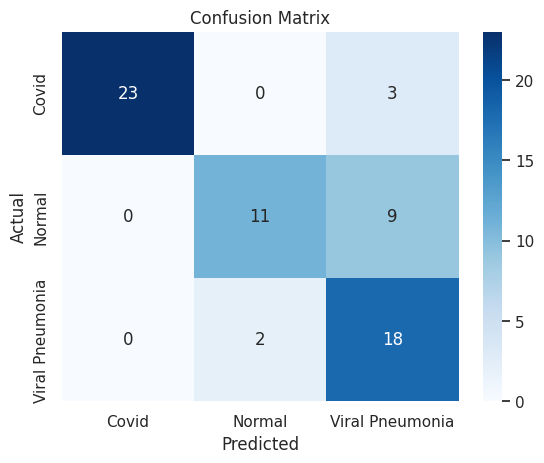

In [ ]:
cm=confusion_matrix(y_test,y_pred)
confusion_df=pd.DataFrame(cm,index=name_classes,columns=name_classes)
sns.heatmap(confusion_df, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**Using VGG16**

pre-trained VGG16 model from Keras. VGG16 is a deep convolutional neural network (CNN) used for image classification tasks. It has 16 layers and is widely used as a feature extractor.

In [ ]:
from tensorflow.keras.applications import VGG16


# Load the pre-trained VGG16 model, excluding the top layers (Fully Connected)
base_model = VGG16(include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Now, build the model by adding your custom layers
model_vgg = Sequential()

# Add the pre-trained VGG16 as the base (feature extractor)
model_vgg.add(base_model)

# Add a few custom layers for classification
model_vgg.add(Flatten())  # Flatten the feature map to a 1D vector
model_vgg.add(Dense(128, activation='relu'))
model_vgg.add(Dropout(0.5))  # Dropout for regularization
model_vgg.add(Dense(64, activation='relu'))
model_vgg.add(Dense(3, activation='softmax'))  # Number of classes is 3




58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Compile the model
model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# View model summary to check architecture
print(model_vgg.summary())

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,934,531 (68.41 MB)

 Trainable params: 3,219,843 (12.28 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [ ]:
# Define image data generators for training and validation
datagen_train_vgg = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


# Flow training and validation data
train_data = datagen_train_vgg.flow_from_directory(
    batch_size=32,
    directory=train_path,
    shuffle=True,
    classes=name_classes,
    target_size=SIZE,  # Use the correct image size
    class_mode='categorical'
)

Found 251 images belonging to 3 classes.


In [ ]:
history = model_vgg.fit(
    train_data,
    epochs=10,
    validation_data=validation_data
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - accuracy: 0.4180 - loss: 1.6668 - val_accuracy: 0.5200 - val_loss: 0.8874
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 46s 356ms/step - accuracy: 0.4545 - loss: 1.2011 - val_accuracy: 0.6000 - val_loss: 0.8726
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 351ms/step - accuracy: 0.5756 - loss: 0.9170 - val_accuracy: 0.7400 - val_loss: 0.7011
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 413ms/step - accuracy: 0.6266 - loss: 0.7342 - val_accuracy: 0.6600 - val_loss: 0.6861
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 352ms/step - accuracy: 0.6253 - loss: 0.7753 - val_accuracy: 0.6400 - val_loss: 0.7491
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 348ms/step - accuracy: 0.6734 - loss: 0.7139 - val_accuracy: 0.6600 - val_loss: 0.6359
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 357ms/step - accuracy: 0.6835 - loss: 0.6728 - val_accuracy: 0.8000 - val_loss: 0.5639
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 456ms/step - accuracy: 0.7839 - loss: 0.5850 - val_accuracy: 0.7000 - val_loss: 0.557

Evaluating Model Performance.

In [ ]:
model_vgg.evaluate(test_data)

66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.9505 - loss: 0.1844


[0.3600796163082123, 0.8636363744735718]

Visualize the performance of the model during training with pre-trained model **VGG16**. By plotting both the training loss and validation loss over epochs, you can:

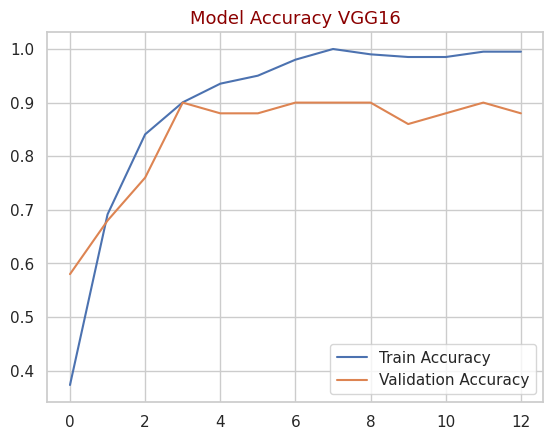

In [ ]:
plt.figure()
plt.plot(hist.history["accuracy"],label="Train Accuracy")
plt.plot(hist.history["val_accuracy"],label="Validation Accuracy")
plt.title("Model Accuracy VGG16")
plt.legend()
plt.show()

Visualize the performance of the model during training with pre-trained model **VGG16**. By plotting both the **training loss** and **validation loss** over epochs, you can:

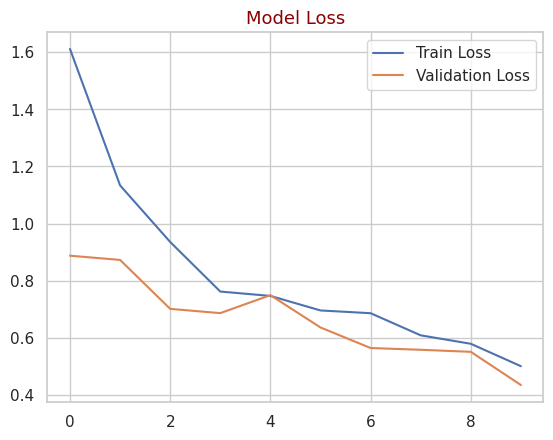

In [ ]:
plt.figure()
plt.plot(history.history["loss"],label="Train Loss")
plt.plot(history.history["val_loss"],label="Validation Loss")
plt.title("Model Loss")
plt.legend()
plt.show()

In [ ]:
predictions=model_vgg.predict(test_data)
y_pred=[np.argmax(probas) for probas in predictions]
y_test=test_data.classes
class_names=test_data.class_indices.keys()

66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Generate classification report
report = classification_report(y_test, y_pred, target_names=name_classes)

# Print the classification report
print(report)


                 precision    recall  f1-score   support

          Covid       0.96      1.00      0.98        26
         Normal       0.80      0.80      0.80        20
Viral Pneumonia       0.79      0.75      0.77        20

       accuracy                           0.86        66
      macro avg       0.85      0.85      0.85        66
   weighted avg       0.86      0.86      0.86        66



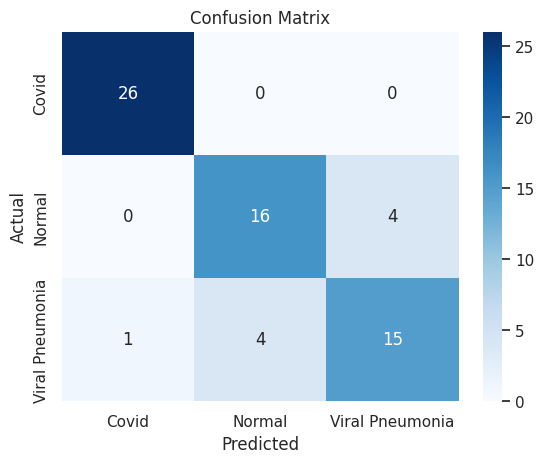

In [ ]:
cm=confusion_matrix(y_test,y_pred)
confusion_df=pd.DataFrame(cm,index=name_classes,columns=name_classes)
sns.heatmap(confusion_df, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Check perfomance of our saved model

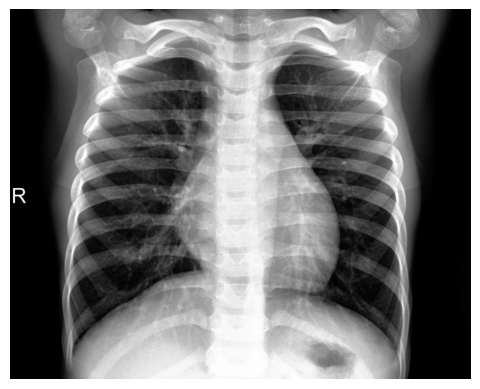

Probability: 0.9351760745048523
Predicted class: Viral Pneumonia


In [ ]:
from PIL import Image
from tensorflow.keras.preprocessing import image




# Step 1: Load your TFLite model
model_path = "/content/converted_model.tflite"
interpreter = tflite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Example image path (replace with your image file path)
image_check = "/content/Covid19-dataset/test/Viral Pneumonia/0101.jpeg"

# Preprocess the image
preprocessed_image = load_image_path(image_check)

input_image = np.expand_dims(preprocessed_image, axis=0)

# Display the original image using matplotlib
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')  # Optionally turn off the axis
plt.show()  # This is necessary to display the image in a script or notebook


# Step 3: Run inference
# Get input and output tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Set the input tensor to the preprocessed image
interpreter.set_tensor(input_details[0]['index'], input_image)

# Invoke the interpreter
interpreter.invoke()

# Step 4: Get the output
output_data = interpreter.get_tensor(output_details[0]['index'])

# Step 5: Post-process the output
# Assuming the output is class probabilities, get the class with the highest probability
predicted_class = np.argmax(output_data, axis=1)

# Class labels (must be the same as used during training)
class_labels = ['Viral Pneumonia', 'Covid', 'Normal']

# Get predicted class label
predicted_class_label = class_labels[predicted_class[0]]

# Print the raw output (probabilities for each class)
print(f"Probability: {max(output_data[0])}")

print(f"Predicted class: {predicted_class_label}")
